In [1]:
import pandas as pd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Bidirectional, GRU 
from keras import Model
from keras import optimizers
from tensorflow import keras

In [2]:
data_full = pd.read_csv('Intrahour Volatility Dataset.csv')
shuffled_data_full = data_full.sample(frac=1, random_state=42)

In [3]:
#We undergo the outlier removal and data reconstruction for both data sets

In [4]:
#Train-test split
splitlimit = int(len(data_full)*0.8)
training_features_a, test_data_a = shuffled_data_full[:splitlimit], shuffled_data_full[splitlimit:]

training_features_b, test_data_b = data_full[:splitlimit], shuffled_data_full[splitlimit:]

In [5]:
X_a = shuffled_data_full[["Return_Squared", "Hourly Volatility"]]
Y_a = shuffled_data_full["target"]
data_set_a = shuffled_data_full[["Return_Squared", "Hourly Volatility", "target"]]

X_b = data_full[["Return_Squared", "Hourly Volatility"]]
Y_b = data_full["target"]
data_set_b = data_full[["Return_Squared", "Hourly Volatility", "target"]]

In [6]:
#Outlier Detection in training_data_features

training_features_a["hourly_volatility_rolling_median"] = training_features_a["Hourly Volatility"].rolling(window=41, center=True, min_periods=1).median()
training_features_a["return_squared_rolling_median"] = training_features_a["Return_Squared"].rolling(window=41, center=True, min_periods=1).median()
training_features_a["volatility minus median"] = (training_features_a["Hourly Volatility"] - training_features_a["hourly_volatility_rolling_median"]).abs()
training_features_a["return minus median"] = (training_features_a["Return_Squared"] - training_features_a["return_squared_rolling_median"]).abs()
volatility_outliers_removed_a = training_features_a[~(training_features_a['volatility minus median'] > 5 * training_features_a['volatility minus median'].median())]
both_outliers_removed_a = volatility_outliers_removed_a[~(volatility_outliers_removed_a['return minus median'] > 5 * volatility_outliers_removed_a['return minus median'].median())]


training_features_b["hourly_volatility_rolling_median"] = training_features_b["Hourly Volatility"].rolling(window=41, center=True, min_periods=1).median()
training_features_b["return_squared_rolling_median"] = training_features_b["Return_Squared"].rolling(window=41, center=True, min_periods=1).median()
training_features_b["volatility minus median"] = (training_features_b["Hourly Volatility"] - training_features_b["hourly_volatility_rolling_median"]).abs()
training_features_b["return minus median"] = (training_features_b["Return_Squared"] - training_features_b["return_squared_rolling_median"]).abs()
volatility_outliers_removed_b = training_features_b[~(training_features_b['volatility minus median'] > 5 * training_features_b['volatility minus median'].median())]
both_outliers_removed_b = volatility_outliers_removed_b[~(volatility_outliers_removed_b['return minus median'] > 5 * volatility_outliers_removed_b['return minus median'].median())]

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_30517/1453491046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features_a["hourly_volatility_rolling_median"] = training_features_a["Hourly Volatility"].rolling(window=41, center=True, min_periods=1).median()
/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_30517/1453491046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features_a["return_squared_rolling_median"] = training_features_a["Return_Squared"].rolling(

In [7]:
X_cleaned_a = both_outliers_removed_a[["Return_Squared", "Hourly Volatility"]]
Y_cleaned_a = both_outliers_removed_a["target"]
data_set_cleaned_a = both_outliers_removed_a[["Return_Squared", "Hourly Volatility", "target"]]

X_cleaned_b = both_outliers_removed_b[["Return_Squared", "Hourly Volatility"]]
Y_cleaned_b = both_outliers_removed_b["target"]
data_set_cleaned_b = both_outliers_removed_b[["Return_Squared", "Hourly Volatility", "target"]]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
training_data_features_scaled_a = scaler_a.fit_transform(X_cleaned_a)
data_set_scaled_a = scaler_a.fit_transform(data_set_cleaned_a)

scaler_b = MinMaxScaler()
training_data_features_scaled_b = scaler_b.fit_transform(X_cleaned_b)
data_set_scaled_b = scaler_b.fit_transform(data_set_cleaned_b)

In [9]:
#Reconstructing training data 

backcandles = 15

Z_a = []

for j in range(2):
    Z_a.append([])
    for i in range(backcandles, training_data_features_scaled_a.shape[0]):
        Z_a[j].append(training_data_features_scaled_a[i-backcandles:i, j])
        
Z_a = np.moveaxis(Z_a, [0], [2])
Z_a, yi_a = np.array(Z_a), np.array(data_set_scaled_a[backcandles-1:, -1])
y_final_a = np.reshape(yi_a,(len(yi_a),1))
y_final_a = y_final_a[1:]


Z_b = []

for j in range(2):
    Z_b.append([])
    for i in range(backcandles, training_data_features_scaled_b.shape[0]):
        Z_b[j].append(training_data_features_scaled_b[i-backcandles:i, j])
        
Z_b = np.moveaxis(Z_b, [0], [2])
Z_b, yi_b = np.array(Z_b), np.array(data_set_scaled_b[backcandles-1:, -1])
y_final_b = np.reshape(yi_b,(len(yi_b),1))
y_final_b = y_final_b[1:]


In [10]:
#LSTM on shuffled data model
lstm_input = Input(shape = (backcandles, 2), name = 'lstm_input')

inputs = LSTM(80, name='first_layer')(lstm_input)

inputs = Dense(1, name='dense_layer')(inputs)

output = Activation('sigmoid', name = 'output')(inputs)

model_a = Model(inputs = lstm_input, outputs = output)

model_a.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

history_a = model_a.fit(x=Z_a, y=y_final_a, epochs = 30, validation_data = (Z_a, y_final_a))

2024-04-22 14:55:30.272913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-22 14:55:30.275271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6749 - accuracy: 0.5973 - val_loss: 0.6741 - val_accuracy: 0.5973
Epoch 2/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6744 - accuracy: 0.5973 - val_loss: 0.6741 - val_accuracy: 0.5973
Epoch 3/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6743 - accuracy: 0.5973 - val_loss: 0.6743 - val_accuracy: 0.5973
Epoch 4/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6743 - accuracy: 0.5973 - val_loss: 0.6741 - val_accuracy: 0.5973
Epoch 5/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6742 - accuracy: 0.5973 - val_loss: 0.6743 - val_accuracy: 0.5973
Epoch 6/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6742 - accuracy: 0.5973 - val_loss: 0.6741 - val_accuracy: 0.5973
Epoch 7/30
1362/1362 [==============================] - 5s 4ms/step - loss: 0.6742 - accuracy: 0.5973 - val_loss: 0.6745 - val_accuracy:

In [11]:
#LSTM on standard data model
lstm_input = Input(shape = (backcandles, 2), name = 'lstm_input')

inputs = LSTM(80, name='first_layer')(lstm_input)

inputs = Dense(1, name='dense_layer')(inputs)

output = Activation('sigmoid', name = 'output')(inputs)

model_b = Model(inputs = lstm_input, outputs = output)

model_b.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

history_b = model_b.fit(x=Z_b, y=y_final_b, epochs = 30, validation_data = (Z_b, y_final_b))

Epoch 1/30
1349/1349 [==============================] - 6s 4ms/step - loss: 0.6438 - accuracy: 0.6224 - val_loss: 0.6206 - val_accuracy: 0.6607
Epoch 2/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.6097 - accuracy: 0.6652 - val_loss: 0.6048 - val_accuracy: 0.6726
Epoch 3/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.6023 - accuracy: 0.6737 - val_loss: 0.5994 - val_accuracy: 0.6719
Epoch 4/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.6003 - accuracy: 0.6740 - val_loss: 0.5983 - val_accuracy: 0.6782
Epoch 5/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5987 - accuracy: 0.6758 - val_loss: 0.5964 - val_accuracy: 0.6785
Epoch 6/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5972 - accuracy: 0.6775 - val_loss: 0.5981 - val_accuracy: 0.6763
Epoch 7/30
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5963 - accuracy: 0.6774 - val_loss: 0.5928 - val_accuracy:

In [12]:
#FFNN on standard data model

input_shape = len(training_data_features_scaled_b[0, :]) 

ff_input = Input(shape=input_shape, name='ff_input')

inputs = Dense(80, activation='relu', name='first_layer')(ff_input)  

# Output layer
outputs = Dense(1, activation='sigmoid', name='output')(inputs)

# Create the model
model_c = Model(inputs=ff_input, outputs=outputs)

# Compile the model
model_c.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_c = model_c.fit(x=training_data_features_scaled_b, y=data_set_scaled_b[:, -1], epochs=30, validation_data=(training_data_features_scaled_b, data_set_scaled_b[:, -1]))

Epoch 1/30
1350/1350 [==============================] - 1s 318us/step - loss: 0.6572 - accuracy: 0.6106 - val_loss: 0.6501 - val_accuracy: 0.6178
Epoch 2/30
1350/1350 [==============================] - 0s 290us/step - loss: 0.6489 - accuracy: 0.6178 - val_loss: 0.6474 - val_accuracy: 0.6186
Epoch 3/30
1350/1350 [==============================] - 0s 290us/step - loss: 0.6467 - accuracy: 0.6190 - val_loss: 0.6457 - val_accuracy: 0.6181
Epoch 4/30
1350/1350 [==============================] - 0s 290us/step - loss: 0.6452 - accuracy: 0.6187 - val_loss: 0.6445 - val_accuracy: 0.6178
Epoch 5/30
1350/1350 [==============================] - 0s 288us/step - loss: 0.6443 - accuracy: 0.6192 - val_loss: 0.6436 - val_accuracy: 0.6191
Epoch 6/30
1350/1350 [==============================] - 0s 287us/step - loss: 0.6438 - accuracy: 0.6166 - val_loss: 0.6439 - val_accuracy: 0.6191
Epoch 7/30
1350/1350 [==============================] - 0s 288us/step - loss: 0.6434 - accuracy: 0.6188 - val_loss: 0.6433 -

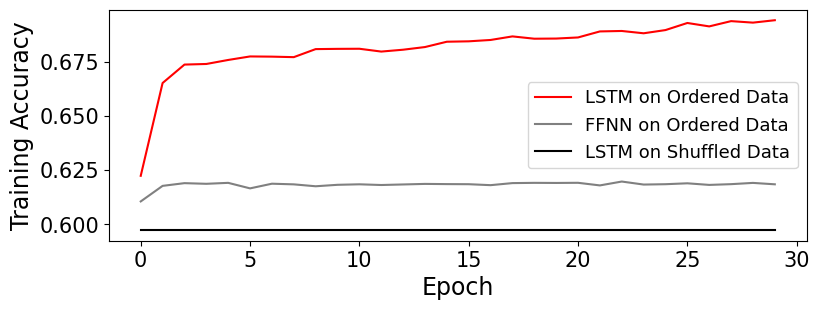

In [13]:
plt.figure(figsize=(9, 3))

plt.plot(history_b.history['accuracy'], color = 'red', label='LSTM on Ordered Data')

plt.plot(history_c.history['accuracy'], color = 'grey', label='FFNN on Ordered Data')

plt.plot(history_a.history['accuracy'], color = 'black', label='LSTM on Shuffled Data')
plt.gca().tick_params(axis='x', labelsize=15)
plt.gca().tick_params(axis='y', labelsize=15) 
plt.xlabel('Epoch', size = 17)
plt.ylabel('Training Accuracy', size = 17)
plt.legend(fontsize = 13)
plt.savefig('Shuffled Vs Ordered Models.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()